<a href="https://colab.research.google.com/github/JonatanGrassi/HelperCapacity/blob/main/HPC/Cuaderno_1_martes_grupo1_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introducción

Acontinuacion observaremos como implementar la ejecucion de una funcion que realiza la traslacion de una imagen en base a un x e y brindado. Tanto en modo secuencial utilizando el cpu como en modo paralelo llevado a cabo con la GPU.A modo informativo mencionamos que la traslacion se consigue trasladando los pixeles de una imagen y la formula que se utilizo fue: 

<center>imagResultado[indiceX + Δx][indiceX + Δy]=imagOriginal[indiceX][indiceY]</center>

Debemos tener en cuenta que en la implementacion hecha en GPU copiamos los componentes RGB de la imagen de modo que es un poco diferente pero sigue la misma logica de utilizar el desplazamiento en los indices que previamente fueron calculados.A continuacion la detallamos

<center> imagResultado[indiceResultado] = imagOriginal[indiceOrigen] componente R del pixel</center>
<center>imagResultado[indiceResultado + 1] = imagOriginal[indiceOrigen + 1] componente G del pixel</center>
<center>imagResultado[indiceResultado + 2] = imagOriginal[indiceOrigen + 2] componente B del pixel</center>


---
# 2 Armado del ambiente
Obtenemos una imagen de acceso publico y la guardamos en el enterno de ejecucion


In [1]:
#@title # 2.1 Definicion de ruta de la imagen a utilizar
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/JonatanGrassi/HelperCapacity/blob/main/HPC/imagen_caballo_prueba_1600x1200.jpg?raw=true" #@param {type:"string"}

#@markdown ---
#!wget https://github.com/JonatanGrassi/HelperCapacity/blob/main/HPC/imagen_caballo_prueba_1600x1200.jpg?raw=true -O imagen.jpg

!wget {url_imagen} -O imagen.jpg



--2021-11-23 16:48:48--  https://github.com/JonatanGrassi/HelperCapacity/blob/main/HPC/imagen_caballo_prueba_1600x1200.jpg?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JonatanGrassi/HelperCapacity/raw/main/HPC/imagen_caballo_prueba_1600x1200.jpg [following]
--2021-11-23 16:48:48--  https://github.com/JonatanGrassi/HelperCapacity/raw/main/HPC/imagen_caballo_prueba_1600x1200.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JonatanGrassi/HelperCapacity/main/HPC/imagen_caballo_prueba_1600x1200.jpg [following]
--2021-11-23 16:48:49--  https://raw.githubusercontent.com/JonatanGrassi/HelperCapacity/main/HPC/imagen_caballo_prueba_1600x1200.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.1

---
## 2.2 Instalacion del módulo CUDA de Python en el entorno.
Asegurece estar en un entorno GPU.

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.3 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627448 sha256=6771135e23dfe2098d94ebb4c2d3dcd3f66885b13d6b8094f04032e356424686
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=6d10bbbdd6ab94501a27ff20436240bfbe030e5b9fadfa4647accb8228cf0de3
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


---
## 2.3 Imports, reserva de memoria,parametros iniciales

In [3]:
#@title Parametros de traslacion
#@markdown ####indicar cuanto quiere trasladar la imagen de su posicion inicial

desplazamiento_vertical =   200#@param {type: "integer"}
desplazamiento_horizontal =   -100#@param {type: "integer"}
#@markdown ---
#@markdown #####Estos parametros son para realizar pruebas se aconceja dejarlos por default si aun no vio la seccion de Experimentacion de este cuaderno
factor_multipliar_hilos =   1#@param {type: ""} 
hilos_por_bloque_dim_x =   15#@param {type: "integer"}
hilos_por_bloque_dim_y =   19#@param {type: "integer"}

despY = desplazamiento_vertical
despX = desplazamiento_horizontal
factor = factor_multipliar_hilos
dimX=hilos_por_bloque_dim_x 
dimY=hilos_por_bloque_dim_y


Reserva de memoria para las matriz inicial y resultado(GPU y CPU) 

**Asegurece de ejecutar este paso cada vez que quiera probar los algoritmos tanto el implementado en CPU como GPU**

In [9]:
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
import numpy
from PIL import Image
try: 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
except ModuleNotFoundError:
  print('\033[91m' + "**Error**:" + '\033[0m' + "\nEs necesario ejecutar el paso2.2 (instalar módulo CUDA de Python)")


tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

img_nombre = 'imagen.jpg'
try:
  image = Image.open( img_nombre )
except FileNotFoundError:
  print ('\033[91m' + "**Error**:" + '\033[0m' + "\n La imagen no fue cargada asegurece de haber ejecutado el paso2 (armado de ambiente)")
img_ancho, img_alto  = image.size

img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.zeros_like( img_O_cpu)
img_R_cpu_sec = numpy.zeros_like(img_O_cpu)

---
# 3 Desarrollo GPU
Ejecución del algoritmo traslacion en GPU de manera paralela

Imagen: imagen.jpg -RGB- [1600, 1200]
Desplazamiento aplicado horizontalmente:[ -100 ]
Desplazamiento aplicado verticalmente:[ 200 ]
Ejecucion paralela de algoritmo de traslacion finalizada


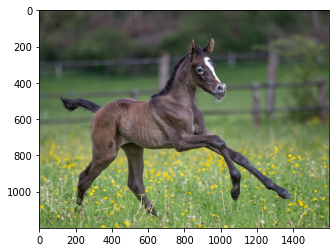

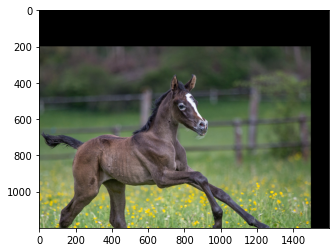

In [10]:
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R,int despX,int despY)
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  int calAcceso = (idx+idy*ancho)*3;
  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho  &&  idy < alto )
  { 
    if(idx + despX < ancho && idy + despY < alto && idx + despX > 0 && idy + despY > 0)
    {
      int acceso = ((idy + despY)*ancho + (idx + despX))*3;
      img_R[acceso] = img_O[calAcceso];
      img_R[acceso + 1] = img_O[calAcceso + 1];  
      img_R[acceso + 2] = img_O[calAcceso + 2];  
    }
  }
}
""") 

kernel = module.get_function("kernel_img")

dim_hilo_x = dimX
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = dimY
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

#multiplico por factor de cantidad de hilos

hilosTotales = dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y*factor_multipliar_hilos
if factor_multipliar_hilos > 1:
  while dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y < hilosTotales:
    dim_bloque_x+=1
    if dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y < hilosTotales:
      dim_bloque_y+=1
else:
  while dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y > hilosTotales:
    dim_bloque_x-=1
    if dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y > hilosTotales:
      dim_bloque_y-=1

tiempo_img_GPU = datetime.now()
try:
  kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu,numpy.int32(despX),numpy.int32(despY), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
  tiempo_img_GPU = datetime.now() - tiempo_img_GPU
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )
  plt.figure()
  imgplot=plt.imshow( img_O_cpu )

  plt.figure()
  imgplot=plt.imshow( img_R_cpu )

  print("Imagen: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )
  print("Desplazamiento aplicado horizontalmente:[",despX,"]")
  print("Desplazamiento aplicado verticalmente:[",despY,"]")
  print("Ejecucion paralela de algoritmo de traslacion finalizada")
except:
  print('\033[91m' + "**Error**:" + '\033[0m' + "\n Las dimensiones establecidas para el bloque superan el maximo tamanio de bloque Eje.[Max = 1024 thread (32,32,1)]")




---
# 4 Desarrollo CPU

Ejecución del algoritmo traslacion en CPU de manera secuencial.

Imagen: imagen.jpg -RGB- [1600, 1200]
Desplazamiento aplicado horizontalmente:[ -100 ]
Desplazamiento aplicado verticalmente:[ 200 ]
Ejecucion secuencial de algoritmo de traslacion finalizada


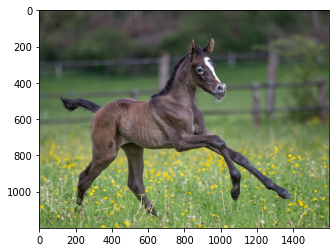

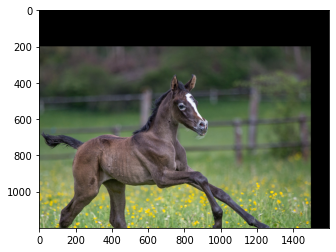

In [11]:
tiempo_img_CPU = datetime.now()

for i in range(len(img_O_cpu)):
  for j in range(len(img_O_cpu[0])):
    if despY >= 0 and despX >= 0:
      if i + despY < img_alto and j + despX < img_ancho:
        img_R_cpu_sec[i + despY][j + despX] = img_O_cpu[i][j]
    if despY < 0 and despX >= 0:
      if i + despY >= 0 and j + despX < img_ancho:
        img_R_cpu_sec[i + despY][j + despX] = img_O_cpu[i][j]
    if despX < 0 and despY >= 0:
      if i + despY < img_alto and j + despX >=0:
        img_R_cpu_sec[i + despY][j + despX] = img_O_cpu[i][j]
    if despX < 0 and despY < 0:
      if i + despY >= 0 and j + despX >=0:
        img_R_cpu_sec[i + despY][j + despX] = img_O_cpu[i][j]

tiempo_img_CPU = datetime.now() - tiempo_img_CPU

plt.figure()
imgplot=plt.imshow( img_O_cpu )

plt.figure()
imgplot=plt.imshow( img_R_cpu_sec )

print("Imagen: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )
print("Desplazamiento aplicado horizontalmente:[",despX,"]")
print("Desplazamiento aplicado verticalmente:[",despY,"]")
print("Ejecucion secuencial de algoritmo de traslacion finalizada")


---
# 5 Metricas

Una vez ejecutados los 2 algoritmos visto en las secciones anteriores prodecemos a ver los resultados y a analizar la comparacion de los mismos

In [12]:
print(" Bloque: [", dim_hilo_x, ",", dim_hilo_y, " ], Grid : [", dim_bloque_x, ",", dim_bloque_y, "]" )
cantidadHilos = dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y
print(" Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", cantidadHilos )
print(" Tiempo GPU  : ", tiempo_en_ms( tiempo_img_GPU ), "[ms]" )
print(" Tiempo CPU  : ", tiempo_en_ms( tiempo_img_CPU ), "[ms]" )
#print(" Tiempo total GPU  : ", tiempo_en_ms( tiempo_total_img_GPU ), "[ms]" )
#print(" Tiempo total CPU  : ", tiempo_en_ms( tiempo_total_img_CPU ), "[ms]" )
speedUp = (tiempo_en_ms(tiempo_img_CPU) / tiempo_en_ms(tiempo_img_GPU))
print(" SpeedUp     : ", speedUp )
print(" Eficiencia  : ", speedUp/cantidadHilos)

 Bloque: [ 15 , 19  ], Grid : [ 107 , 64 ]
 Total de Thread: [ 1605 , 1216  ]  =  1951680
 Tiempo GPU  :  0.263 [ms]
 Tiempo CPU  :  2853.638 [ms]
 SpeedUp     :  10850.334600760456
 Eficiencia  :  0.005559484444560817


## 5.1 informacion sobre la GPU donde se esta realizando las pruebas

In [15]:
!cd /usr/local/cuda/samples/1_Utilities/deviceQuery/; make > /dev/null
!/usr/local/cuda/samples/1_Utilities/deviceQuery/deviceQuery | grep Maximum

  Maximum Texture Dimension Size (x,y,z)         1D=(65536), 2D=(65536, 65536), 3D=(4096, 4096, 4096)
  Maximum Layered 1D Texture Size, (num) layers  1D=(16384), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(16384, 16384), 2048 layers
  Maximum number of threads per multiprocessor:  2048
  Maximum number of threads per block:           1024
  Maximum memory pitch:                          2147483647 bytes


---
# 6 Conclusiones

## Tiempos GPU-CPU
Podemos observar que el tiempo utilizado consumido en el procesamiento de la imagen de forma secuencial difere en el orden de los 3 segundos del procesamiento en GPU, se denota una diferencia importante que crecera a medida que el volumen de datos se incremente. Es decir, imagenes de una resolucion alta como por ejemplo 4096 x 2160 utilizando un algoritmo secuencial con complejidad O² tardarian aproximadamente 20 segundos, mientras que utilizando GPU no superaria los 3 milisegundos.

## SpeedUp
Se observa que se consiguio un speedUp de alrededor de 10850 este valor hacer referencia a la ganacia que se consiguio en relacion a la utilizacion de un algoritmo secuencial

## Eficiencia
Eficiencia en este caso aplicado sobre la cantidad de thread utilizada, da la idea del tiempo distribuidos entre los thread que se usaron para procesar la imagen

---
# 7 Experimentacion

## ¿Qué sucede si se planifican la mitad de los hilos-gpu?
---
factor_multipliar_hilos este parametro que se encuentra en la seccion desarrollo de GPU permite poder cambiar la cantidad de thread que se van a utilizar. Para poder responder esta pregunta colocamos un factor 0.5 que permitira generar la mitad de thread ,tener en cuenta que lo implementamos cambiando las dimensiones de grid pero no de los bloques,para el caso siempre sera bloques de (15,19) aunque cambiara el bloque dependiendo el tamaño(ancho,alto) de la imagen y el factor de multiplicidad que coloquemos.

Haremos la comparacion de tiempos obtenidos.
con factor de multiplicad 1
para una imagen de [1600, 1200] (alto,ancho) se utilizaron 1920000 hilos

El tiempo que tardo utilizando GPU con 1920000 hilos fue de 0.216 ms

Al disminuir la cantidad de hilos a la mitad (948150) obtuvimos un tiempo de procesamiento de 0.208 ms pero el resultado de la traslacion no fue el correcto ya que al utilizar menos cantidad de hilos de los necesarios para procesar la imagen partes de la misma no fueron copiadas en la imagen resultado, aplicando la traslacion pero dejando incompleta parte de la imagen

## ¿Qué sucede si se planifican el doble de hilos-gpu?
---

Haremos la comparacion de tiempos obtenidos.
con factor de multiplicad 1
para una imagen de [1600, 1200] (alto,ancho) se utilizaron 1920000 hilos

El tiempo que tardo utilizando GPU con 1920000 hilos fue de 0.216 ms

Al aumentar la cantidad de hilos el doble (3843750) obtuvimos un tiempo de procesamiento de 0.211, un tiempo de orden similar al anterior .Esto sucede debido a que estoy planificando hilos por demas entonces aquellos que no sean necesarios ejecutaran el kernel pero no realizaran ninguna accion por lo tanto no se vera mejoras en los tiempos.

## ¿Qué cambios hay que hacer para procesar la mitad inicial de la imagen origen?
---
if( idx < ancho && idy < alto <b> /2 </b> ) si agregamos en la condicion de este if que se encuentra dentro del kernel los hilos encargados de procesar la mitad final de la imagen no realizaran la traslacion.

## ¿Qué cambios hay que hacer para procesar la mitad final de la imagen destino?
---
if( idx < ancho && <b> idy > alto/2 </b> && idy < alto) si agregamos en la condicion de este if ,lo marcado en negrita, que se encuentra dentro del kernel los hilos encargados de procesar la mitad superior de la imagen no realizaran la traslacion.


## ¿Cuál es el resultado si se utilizan un tamaño de bloques igual a la cantidad máxima de hilos soportada por el GPGPU?
---
Si observamos la fila Maximum number of threads per block de la seccion 6.1 podremos ver la maxima cantidad de hilos por bloque en este caso 1024, para poder determinar las dimensiones del bloque debemos asegurarnos de no superar dicho valor por lo tanto podemos establecer un bloque que sea (33,32,1)

32 * 32 * 1 = 1024

el tiempo obtenido usando la maxima cantidad de hilos por bloque fue de 0.221 [ms] .Utilizar la maxima cantidad de hilos por bloque determina que generaremos en nuestro caso una grilla con las minimas dimensiones posibles() para el procesado de la imagen utilizada(50,38).

Se puede comprobar esta experiencia cambiando los valores hilos_por_bloque_dim_x y hilos_por_bloque_dim_y que se encuentra en la seccion 2.3

---
# 8 Bibliografía

[1] MARKDOWN SYNTAX Colab: [En Linea](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Vector11 <<difference between threadIdx, blockIdx statements>> 9/9/2009 [En linea]: https://forums.developer.nvidia.com/tdifference-between-threadidx-blockidx-statements/12161

[3] Erik German Ramos Perez << Practicas academicas en Inteligencia Artificial.>> 2020 [En linea] https://www.utm.mx/pef/pades/2019/acad/entregable4.pdf

[4] Joaquin Obregon<<Computación Heterogénea (Potencia GPU+CPU) Heterogeneous Computing (GPU+CPU Power)>>2011[En linea]https://www.academia.edu/47123595/Computaci%C3%B3n_Heterog%C3%A9nea_Potencia_GPU_CPU_Heterogeneous_Computing_GPU_CPU_Power_

[5] Waldo Valiente <<  Ejemplos de OpenMP y OpenMPI usados desde Colab >>, 18 Nov 2020 [En Linea] https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%201%20-%20Vectores%20-%20OpenMP.ipynb

[6] Waldo Valiente << Ejercicio escala de grises >>, 27 jun 2021,[En linea] https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb 
